<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/CNN%E3%81%AB%E3%82%88%E3%82%8B%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5%EF%BC%88%E9%80%9A%E5%B8%B8%E7%89%88%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 事前学習済み CNN (ResNet18) バックボーンを用いた異常検知 (特徴量に対して 単純なkNNを用いた異常検知)
# 使っている特徴量は、ResNet18 の最後の畳み込みブロック（layer4）の出力を Global Average Pooling した後の 512 次元ベクトル（＝本来 fc に入る直前の埋め込み）。
# - 正常データのみで学習 (特徴量バンク作成)
# - 異常スコア = 1 - 正常特徴量バンクとの上位k個コサイン類似度の平均
# - 閾値 = 正常データの検証スコアのパーセンタイル
# - デモデータセット: CIFAR-10 (ある1クラスを "正常" として扱う)　ここでは"ship"を正常画像とする

# ================== メモ ==================
# - 実運用では「正常のみ」で特徴量バンクを作成し、推論時に score>=thr なら異常と判断します。
# - 独自データを使う場合は USE_OWN_FOLDER=True にし、上のディレクトリ構成で画像を配置してください。
# - TOPK, THRESH_PCT, NORMAL_CLASS は用途に合わせて調整してください。
# - Mahalanobis 距離やパッチ特徴（中間層）を使うと精度がさらに向上します。

import os, math, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

In [2]:
# scikit-learn がない場合のインストール:
# !pip -q install scikit-learn
from sklearn.metrics import roc_auc_score, average_precision_score

In [3]:
# ================== パラメータ ==================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
NUM_WORKERS = 2
NORMAL_CLASS = "ship"   # CIFAR-10 の中で "正常" と扱うクラス名
TOPK = 5                # 上位k個のコサイン類似度を平均
THRESH_PCT = 99.0       # 正常検証スコアのパーセンタイルで閾値を決定
VAL_SPLIT = 0.1         # 正常データのうち検証用に使う割合
RANDOM_SEED = 1337
USE_OWN_FOLDER = False  # True にすると下の "独自フォルダ" を使用する

random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)

In [4]:
# ================== 前処理 (ImageNet) ==================
IM_SIZE = 224
IM_MEAN = [0.485, 0.456, 0.406]
IM_STD  = [0.229, 0.224, 0.225]
t_train = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IM_MEAN, IM_STD),
])
t_test = t_train

In [5]:
# ================== バックボーン: ResNet18 (ImageNet 事前学習済み) ==================
try:
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    backbone = models.resnet18(weights=weights)
except Exception:
    backbone = models.resnet18(pretrained=True)  # 古い torchvision 用フォールバック
backbone.fc = nn.Identity()   # 出力を 512次元特徴量に
backbone.eval().to(DEVICE)
for p in backbone.parameters(): p.requires_grad_(False)

In [6]:
# ================== データセット (デモ: CIFAR-10) ==================
if not USE_OWN_FOLDER:
    root = "./data"
    train_set = datasets.CIFAR10(root, train=True,  download=True, transform=t_train)
    test_set  = datasets.CIFAR10(root, train=False, download=True, transform=t_test)
    classes = train_set.classes  # ['airplane','automobile',...]
    normal_idx = classes.index(NORMAL_CLASS)

    # 正常 / 異常のインデックスを作成
    tr_idx_norm = [i for i,(_,y) in enumerate(train_set) if y == normal_idx]
    te_idx_norm = [i for i,(_,y) in enumerate(test_set)  if y == normal_idx]
    te_idx_anom = [i for i,(_,y) in enumerate(test_set)  if y != normal_idx]

    # 正常データを特徴量バンク用と検証用に分割
    n_val = max(1, int(len(tr_idx_norm) * VAL_SPLIT))
    tr_idx_norm_shuffled = tr_idx_norm.copy()
    random.shuffle(tr_idx_norm_shuffled)
    val_idx_norm = tr_idx_norm_shuffled[:n_val]
    bank_idx_norm = tr_idx_norm_shuffled[n_val:]

    ds_bank = Subset(train_set, bank_idx_norm)   # 特徴量バンク (正常のみ)
    ds_val  = Subset(train_set, val_idx_norm)    # 閾値調整用 (正常のみ)
    ds_test_norm  = Subset(test_set, te_idx_norm)
    ds_test_anom  = Subset(test_set, te_idx_anom)
else:
    # ================== 独自フォルダ (オプション) ==================
    # 想定ディレクトリ構成:
    # data/
    #   train_normal/ ... 正常画像
    #   val_normal/   ... 正常画像 (なければ train を分割)
    #   test_normal/  ... 正常画像
    #   test_anomaly/ ... 異常画像
    root = "./data"
    def folder(path): return datasets.ImageFolder(path, transform=t_test)
    ds_bank = folder(os.path.join(root, "train_normal"))
    val_path = os.path.join(root, "val_normal")
    ds_val  = folder(val_path) if os.path.isdir(val_path) and len(os.listdir(val_path))>0 else ds_bank
    ds_test_norm  = folder(os.path.join(root, "test_normal"))
    ds_test_anom  = folder(os.path.join(root, "test_anomaly"))

In [7]:
# ================== データローダー ==================
def mk_loader(ds, shuffle=False):
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=NUM_WORKERS,
                      pin_memory=(DEVICE=="cuda"))

ld_bank = mk_loader(ds_bank, shuffle=False)
ld_val  = mk_loader(ds_val, shuffle=False)
ld_tn   = mk_loader(ds_test_norm, shuffle=False)
ld_ta   = mk_loader(ds_test_anom, shuffle=False)

In [8]:
# ================== 特徴量抽出 ==================
# 学修済ネットワークをつかうため勾配の学習は行わない
@torch.no_grad()
def extract_features(loader):
    feats, idxs = [], []
    for i,(x, *rest) in enumerate(loader):
        x = x.to(DEVICE, non_blocking=True)
        f = backbone(x)                 # [B, 512]
        f = F.normalize(f, dim=1)       # コサイン類似度に適した正規化
        feats.append(f.cpu())
    return torch.cat(feats, dim=0)

print("Extracting features...")
F_bank = extract_features(ld_bank)     # [N_bank, D]
F_val  = extract_features(ld_val)      # [N_val,  D]
F_tn   = extract_features(ld_tn)       # [N_tn,   D]
F_ta   = extract_features(ld_ta)       # [N_ta,   D]
print("Done.", F_bank.shape)


Extracting features...
Done. torch.Size([4500, 512])


In [9]:
# ================== kNN 異常スコア ==================
def knn_anomaly_score(F_query, F_ref, topk=TOPK):
    # 特徴量は正規化済みなのでコサイン類似度 = Q @ R^Tで評価している
    # スコア = 上位k個の類似度の平均を 1 から引いた値
    # (0=正常に近い, 2=最悪の異常ケース)
    sims = F_query @ F_ref.T
    topk_sim, _ = torch.topk(sims, k=min(topk, F_ref.shape[0]), dim=1, largest=True)
    score = 1.0 - topk_sim.mean(dim=1)
    return score.cpu().numpy()

Scoring...
Threshold (from normal val 99.0th pct): 0.18174
AUC = 0.9506, AP = 0.9941, Accuracy@thr = 0.7320
Mean scores -> normal: 0.1293, anomaly: 0.2079


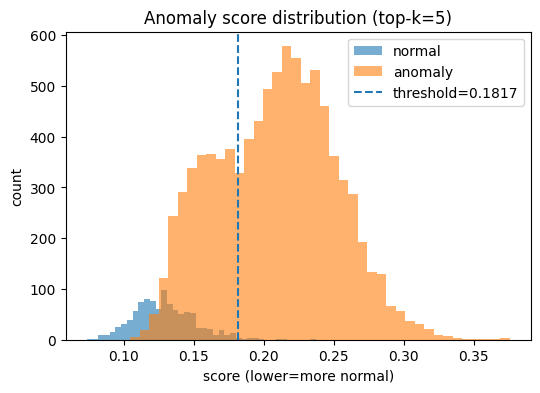

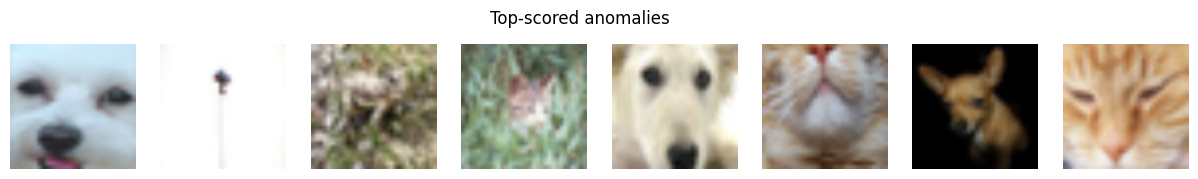

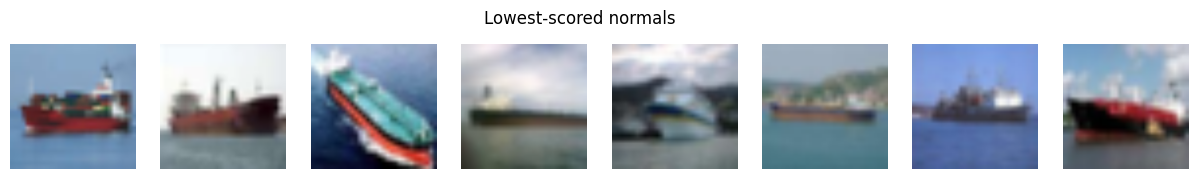

In [10]:
print("Scoring...")
val_scores = knn_anomaly_score(F_val, F_bank)     # 正常のみ
tn_scores  = knn_anomaly_score(F_tn,  F_bank)
ta_scores  = knn_anomaly_score(F_ta,  F_bank)

# 正常検証データから閾値を決定
thr = np.percentile(val_scores, THRESH_PCT)
print(f"Threshold (from normal val {THRESH_PCT:.1f}th pct): {thr:.5f}")

# ================== テストデータで評価 (デモ; ラベルが必要) ==================
y_tn = np.zeros(len(tn_scores), dtype=int)
y_ta = np.ones(len(ta_scores), dtype=int)
scores = np.concatenate([tn_scores, ta_scores])
labels = np.concatenate([y_tn, y_ta])

auc = roc_auc_score(labels, scores)
ap  = average_precision_score(labels, scores)
pred = (scores >= thr).astype(int)
acc = (pred == labels).mean()
print(f"AUC = {auc:.4f}, AP = {ap:.4f}, Accuracy@thr = {acc:.4f}")
print(f"Mean scores -> normal: {tn_scores.mean():.4f}, anomaly: {ta_scores.mean():.4f}")

# ================== グラフ描画 ==================
plt.figure(figsize=(6,4))
plt.hist(tn_scores, bins=40, alpha=0.6, label="normal")
plt.hist(ta_scores, bins=40, alpha=0.6, label="anomaly")
plt.axvline(thr, linestyle="--", label=f"threshold={thr:.4f}")
plt.title(f"Anomaly score distribution (top-k={TOPK})")
plt.xlabel("score (lower=more normal)")
plt.ylabel("count")
plt.legend(); plt.show()

# 異常スコアの高低サンプルを可視化 (テストセット)
def inv_norm(x):
    mean = torch.tensor(IM_MEAN).view(3,1,1); std = torch.tensor(IM_STD).view(3,1,1)
    return (x*std + mean).clamp(0,1)

def show_samples(dataset_subset, scores_arr, title, n=8, highest=True):
    # dataset_subset: Subset または Dataset
    # 元データを取り出して再度変換して表示
    idx_sorted = np.argsort(scores_arr)
    if highest: idx_sorted = idx_sorted[::-1]
    idx_pick = idx_sorted[:n]
    loader = DataLoader(dataset_subset, batch_size=1, shuffle=False, num_workers=0)
    imgs = []
    for i, (x, *_) in enumerate(loader):
        if i in idx_pick:
            imgs.append(inv_norm(x[0]).permute(1,2,0).numpy())
        if len(imgs) >= n: break
    cols = n
    plt.figure(figsize=(1.9*cols, 2.0))
    for i,img in enumerate(imgs):
        plt.subplot(1, cols, i+1); plt.imshow(img); plt.axis("off")
    plt.suptitle(title); plt.show()

show_samples(ds_test_anom, ta_scores, "Top-scored anomalies", n=8, highest=True)
show_samples(ds_test_norm, tn_scores, "Lowest-scored normals", n=8, highest=False)
